# The Mouse Cortical Model + Advanced Features

The goal of this chapter is an introduction to how with more realistic models one might use some of the advanced features of the BMTK. 

These features can be useful whether you are building a more realistic network model from scratch or intend to carry out simulations of an existing model like the Allen Institute models of the Mouse Primary Visual Cortex (see [here](https://portal.brain-map.org/explore/models/mv1-all-layers)). 

In modeling practice, it is often the case that one needs to use such an existing model with some modifications. Many possibilities to do so are offered by the modular SONATA format, where one can modify the config files and/or the data files containing components of the model, such as nodes, edges, cell and synapse models, etc. 

In addition, BMTK offers ways to change certain aspects of the models at runtime. This can sometimes be preferable to replacing the static structure of the model, for example, in cases when one may need to sample many different conditions in separate simulations. Rebuilding components of the model for every simulation may be cumbersome in such a situation. Some approaches for runtime modifications are illustrated below. 

Throughout this chapter, we will use a reduced version of the network model of the Layer 4 (L4) from the mouse V1 (full version can be found [here](https://portal.brain-map.org/explore/models/mv1-all-layers)). The complete V1 model (230,000 neurons) or just the model of V1 L4 (45,000 neurons) are too large for quick training simulations. Therefore, we are using here a smaller (2,300 neurons) network model with less diversity and complexity in the node and edge types; however, all the operations illustrated in this chapter can be successfully applied to much larger and more complex networks.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import h5py
import glob
import nest

from bmtk.analyzer.spike_trains import plot_rates_boxplot, plot_rates, plot_raster
from bmtk.utils import sonata
from bmtk.utils.reports import SpikeTrains


pd.set_option('display.max_rows', None)

[INFO] [2022.7.14 9:23:16 /home/ping/bmtk_proj/nest-simulator-2.20.1/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2022.7.14 9:23:16 /home/ping/bmtk_proj/nest-simulator-2.20.1/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.1
 Built: Jan  1 2022 23:06:15

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## [6A. Building the Model](6A.%20Building%20the%20L4%20Network.ipynb)

We have already built a reduced model of the Mouse Primary Visual Cortex with only Layer 4 cells which has been saved in the **network/** directory. The rules used to build the network are not necessary for the rest of the chapter, and can be time consuming to rebuild from scratch. But should one be interested in how the network was built more details can be found [here](6A.%20Building%20the%20L4%20Network.ipynb).

The core of the network is internal "L4" (Layer 4) cells saved in the l4_nodes.h5 and l4_node_types.csv files. To get a sense of the make-up of the network let's use ```bmtk.utils.sonata``` functionality to load the nodes into a Pandas DataFrame:

In [2]:
net = sonata.File(
    data_files='network/l4_nodes.h5',
    data_type_files='network/l4_node_types.csv'
)
l4_nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
l4_nodes_df[['layer', 'ei', 'model_name',  'dynamics_params', 'model_template', 'model_type','node_id']]  \
    .groupby(['layer', 'ei', 'model_name', 'model_template', 'model_type', 'dynamics_params'])   \
    .agg('count')  \
    .rename(columns={'node_id':'node_count'})

node_count
layer ei model_name       model_template        model_type   dynamics_params                               
VisL4 e  Rorb_314642645   nest:glif_lif_asc_psc point_neuron 314642645_glif_lif_asc_config.json         594
         Scnn1a_517982558 nest:glif_lif_asc_psc point_neuron 517982558_glif_lif_asc_config.json         686
         other_483018019  nest:glif_lif_asc_psc point_neuron 483018019_glif_lif_asc_config.json         732
      i  Htr3a_474626527  nest:glif_lif_asc_psc point_neuron 474626527_glif_lif_asc_config.json          61
         Pvalb_478958894  nest:glif_lif_asc_psc point_neuron 478958894_glif_lif_asc_config.json         223
         Sst_501282204    nest:glif_lif_asc_psc point_neuron 501282204_glif_lif_asc_config.json         119

Let us also look at the overall makeup of the recurrent (L4 --> L4) connections:

In [3]:
l4_edges_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ').sort_values(['dynamics_params', 'target_query'])
with h5py.File('network/l4_l4_edges.h5', 'r') as h5:
    edge_ids, edge_counts = np.unique(h5['/edges/l4_to_l4/edge_type_id'][()], return_counts=True)
    edge_counts_df = pd.DataFrame({'edge_type_id': edge_ids, 'counts': edge_counts})
    l4_edges_df = l4_edges_df.merge(edge_counts_df, how='left', on='edge_type_id')

l4_edges_df.set_index(['edge_type_id', 'target_query', 'source_query', 'dynamics_params'])

,,,,syn_weight,delay,weight_sigma,weight_function,model_template,counts
edge_type_id,target_query,source_query,dynamics_params,,,,,,
107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,26060
113,cell_line=='e4Rorb',cell_line=='e4Scnn1a',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,29915
125,cell_line=='e4Rorb',cell_line=='e4other',e2e.json,5.154132,1.3,30.0,DirectionRule_EE,static_synapse,32074
108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,29609
114,cell_line=='e4Scnn1a',cell_line=='e4Scnn1a',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,34341
126,cell_line=='e4Scnn1a',cell_line=='e4other',e2e.json,13.687266,1.3,30.0,DirectionRule_EE,static_synapse,36462
110,cell_line=='e4other',cell_line=='e4Rorb',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,32077
116,cell_line=='e4other',cell_line=='e4Scnn1a',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,36294
128,cell_line=='e4other',cell_line=='e4other',e2e.json,5.443508,1.3,30.0,DirectionRule_EE,static_synapse,38328


## [6B. Generating Synaptic Inputs](6B.%20Creating%20Synaptic%20Inputs.ipynb)

Next step is generating spike-train inputs to the network model.

One can create any number of external node populations that provide such inputs. Here we will use two such populations. Since our network model is based on the mouse V1, which receives major inputs from the Lateral Geniculate Nucleus (LGN) of the thalamus, one of the external populations, labeled “lgn”, will represent these visual inputs. The other will represent inputs from everything else (the rest of the brain outside of V1 and LGN) to V1 – something one can call the background input, hence the population name “bkg”. These two populations provide feed-forward synaptic inputs into our simplified V1 L4 model (of course, in reality, V1 provides feedback to the thalamus as well as sends signals to other parts of the brain too).

Generating realistic inputs for the full "lgn" model using ```FilterNet``` can be time consuming, so we already pre-generated them in the **inputs/** directory. The files _spikes.\*.h5_ within this directory contain SONATA spike-trains we can use when running simulations of our model:

In [4]:
print('Valid SONATA inputs:')
for spikes_file in glob.glob('inputs/spikes.*.h5'):
    print('->', spikes_file)

Valid SONATA inputs:
-> inputs/spikes.gratings.45deg_4Hz.h5
-> inputs/spikes.gratings.0deg_2Hz.h5
-> inputs/spikes.gratings.45deg_2Hz.h5
-> inputs/spikes.gratings.90deg_2Hz.h5
-> inputs/spikes.gratings.90deg_4Hz.h5
-> inputs/spikes.gratings.0deg_4Hz.h5


However should you want to generate a different set of input spikes, or regenerate the existing ones (required if the lgn coordinates have been changed, since spiking is dependent on the position of the receptive field in the visual space) please see the notebook [here](6B.%20Creating%20Synaptic%20Inputs.ipynb).

## 6C. Running the Model


#### LGN feedforward connections only

First we'll start by testing and optimizing the network with LGN feedforward connections only, that is without the recurrent connections. The main focus will be on the synaptic weights or *syn_weight* parameter such that the various cell-type models are spiking with an appropriate baseline firing-rate.

To run the simulation with only feedforward synaptic connections all we need to do is adjust the "network" section of the configuration so that "l4->l4" connections are excluded.

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/bkg_nodes.h5",
        "node_types_file": "$NETWORK_DIR/bkg_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/bkg_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/bkg_l4_edge_types.csv"
      }
    ]
  }

```

In [5]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.feedforward.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-14 09:23:34,953 [INFO] Created log file
2022-07-14 09:23:34,971 [INFO] Batch processing nodes for l4/0.
2022-07-14 09:23:35,047 [INFO] Batch processing nodes for lgn/0.
2022-07-14 09:23:35,055 [INFO] Batch processing nodes for bkg/0.
2022-07-14 09:23:35,091 [INFO] Setting up output directory
2022-07-14 09:23:35,093 [INFO] Building cells.
2022-07-14 09:23:35,117 [INFO] Building recurrent connections
2022-07-14 09:23:35,118 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-14 09:23:40,541 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-14 09:23:40,582 [INFO] Network created.
2022-07-14 09:23:40,638 [INFO] Starting Simulation
2022-07-14 09:23:46,475 [INFO] Simulation finished, finalizing results.
2022-07-14 09:23:46,726 [INFO] Done.


We can quickly analyze our results by looking at the spike raster and firing rates grouped by their cell type.

Note that in the plot below all i4Sst and i4Htr3a cells produce spike trains that are identical to each other. This is because in this simplified model Sst and Htr3a cells do not receive LGN inputs, and, in the absence of recurrent connections, the only input these cells ‘see’ is that from the background (bkg) which provides identical inputs to all cells of a given type. In this simplified network model, we are using a single cell model for Sst type (and likewise for Htr3a type), and each cell of a given type receives the same number and strengths of synapses from bkg. Thus, at this point all these cells receive identical inputs. In reality, such bkg inputs would be different across cells of the same type. 

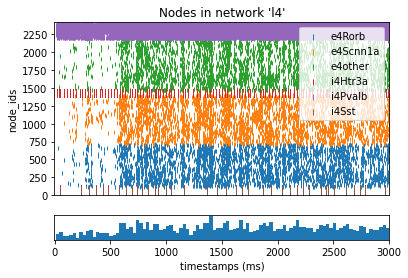

In [6]:
_ = plot_raster(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

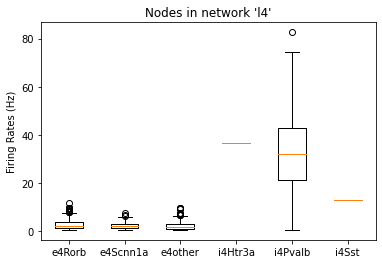

In [7]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.feedforward.json', group_by='cell_line')

However, these results don’t tell us how well-tuned the neurons are to the given stimuli. **tuning_angle** is an optional, user-defined property assigned to each node in the SONATA files for this model. Basically, it indicates the direction of motion in the visual space that the cell is intended to prefer. Whether the cell actually prefers that direction or not in any given model and simulation is not guaranteed – that depends on how the model is built and conditions of the simulation. We can use this parameter to inform the lgn connectivity (and also recurrent connectivity) of the units during model construction and then check whether the simulations show the intended direction selectivity (for more details see [Billeh et al., 2020](https://www.cell.com/neuron/fulltext/S0896-6273(20)30067-2)).

The function below plots the firing rates of excitatory or inhibitory neurons as a function of their **tuning_angle** property.

In [8]:
def plot_tuning_angle_fr(spikes_path, fr_window=(500.0, 3000.0), avg_window=15):
    dur_secs = (fr_window[1] - fr_window[0]) / 1000.0

    net = sonata.File(
        data_files='network/l4_nodes.h5',
        data_type_files='network/l4_node_types.csv'
    )
    nodes_df = net.nodes['l4'].to_dataframe(index_by_id=False)
    nodes_df = nodes_df[['node_id', 'node_type_id', 'model_name', 'tuning_angle', 'model_type', 'layer', 'ei']]
    
    spikes = SpikeTrains.load(spikes_path)
    spikes_df = spikes.to_dataframe(population='l4')

    fr_df = spikes_df['node_ids'][spikes_df.timestamps.between(fr_window[0],fr_window[1])] \
                                  .value_counts()  \
                                  .rename_axis('node_id')  \
                                  .reset_index(name='spike_counts')
    
    fr_df['firing_rates'] = fr_df['spike_counts'].values / dur_secs
    fr_df['node_id'] = fr_df['node_id'].astype(np.uint64)
    fr_df = fr_df.merge(nodes_df, how='right', on='node_id')       
    fr_df['spike_counts'] = fr_df['spike_counts'].fillna(0.0)   
    fr_df['firing_rates'] = fr_df['firing_rates'].fillna(0.0)

    def create_subplot(ax, grp_df, label):
        ax.scatter(grp_df['tuning_angle'], grp_df['firing_rates'], s=2)
        
        fr_avgs = pd.DataFrame({
            'tuning_rounded': np.floor(grp_df['tuning_angle']),
            'firing_rates': grp_df['firing_rates']
        }).groupby('tuning_rounded').agg(np.mean)
        
        if avg_window and len(fr_avgs['firing_rates']) > avg_window:
            tuning_even_spaced = pd.DataFrame({
                'tuning_rounded':np.arange(360)
            })
            fr_avgs=fr_avgs.merge(tuning_even_spaced, how='right', on='tuning_rounded')
            fr_avgs['firing_rates_avg'] = fr_avgs['firing_rates'].rolling(avg_window, min_periods=1).mean()

        ax.plot(fr_avgs['firing_rates_avg'], c='r', linewidth=3, label=label)
        ax.legend(fontsize=10, loc='upper right')
        ax.set_xlabel('Tuning Angle (deg)')
        ax.set_ylabel('Firing Rate (Hz)')

    # plot excitatory cells by layer
    nrows = 2
    fig, axes = plt.subplots(nrows, 1, figsize=(10, 5))
    for r, layer in enumerate(['VisL4']):
        exc_df = fr_df[(fr_df['ei'] == 'e') & (fr_df['layer'] == layer)]
        create_subplot(axes[r], exc_df, 'exc; {}'.format(layer))

    # plot inhibitory cells
    inh_df = fr_df[fr_df['ei'] == 'i']
    create_subplot(axes[r+1], inh_df, 'inh; ALL')

    for r in range(nrows):
        if r != (nrows - 1):
            axes[r].set_xticklabels([])
            
    plt.show()


Now we use the function above to plot the firing rates of neurons as a function of their assigned “tuning_angle” (blue dots), as well as a running average (red line). 

The stimulus we apply here is a grating drifting in the 90 degrees direction. Due to the way we constructed the LGN inputs (following what is known about inputs converging from LGN to V1), the L4 neurons with tuning angle close to 90 degrees show slightly elevated firing rate relative to all other neurons. However, the difference is small.

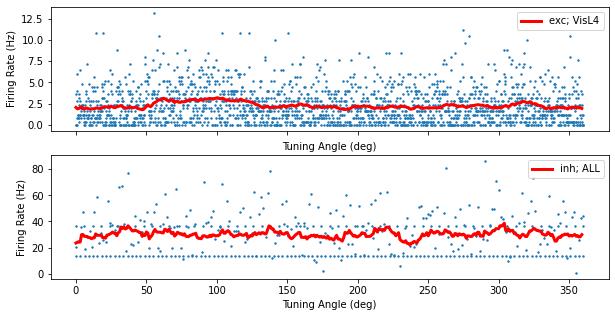

In [9]:
plot_tuning_angle_fr('output_feedforward/spikes.h5')

Let us proceed with the fully recurrent model to see if the situation changes.

#### Full model

We are now ready to run the simulation with the l4-->l4 recurrent connections added back. All we need to do is add the l4-->l4 edges files to our config file:

```json
  "networks": {
    "nodes": [
      {
        "nodes_file": "$NETWORK_DIR/l4_nodes.h5",
        "node_types_file": "$NETWORK_DIR/l4_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/lgn_nodes.h5",
        "node_types_file": "$NETWORK_DIR/lgn_node_types.csv"
      },
      {
        "nodes_file": "$NETWORK_DIR/bkg_nodes.h5",
        "node_types_file": "$NETWORK_DIR/bkg_node_types.csv"
      }
    ],
    "edges": [
      {
        "edges_file": "$NETWORK_DIR/l4_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/l4_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/lgn_l4_edges.h5",
        "edge_types_file": "$NETWORK_DIR/lgn_l4_edge_types.csv"
      },
      {
        "edges_file": "$NETWORK_DIR/bkg_v1_edges.h5",
        "edge_types_file": "$NETWORK_DIR/bkg_v1_edge_types.csv"
      }
    ]
  }
```

However, should we run the simulation as before we would get the following error:
    
<div class="alert alert-block alert-danger">
<b>[ERROR]</b> Unable to calculate synaptic weight for "l4_to_l4" edges, missing "weight_function" attribute value DirectionRule_others function.
</div>

This is because in our L4 --> L4 connections we added a special property "**weight_function**", with rules depending on whether the connections are excitatory-to-excitatory (DirectionRule_EE) or otherwise (DirectionRule_others).

In [10]:
edge_types_df = pd.read_csv('network/l4_l4_edge_types.csv', sep=' ')
edge_types_df.iloc[5:10].style.applymap(lambda *_: 'background-color: yellow', subset=pd.IndexSlice[:, 'weight_function'])

,edge_type_id,target_query,source_query,dynamics_params,syn_weight,delay,weight_sigma,weight_function,model_template
5,105,cell_line=='i4Pvalb',cell_line=='i4Sst',i2i.json,-1.120146,1.500000,50.000000,DirectionRule_others,static_synapse
6,106,cell_line=='i4Sst',cell_line=='e4Rorb',e2i.json,3.388120,1.500000,90.000000,DirectionRule_others,static_synapse
7,107,cell_line=='e4Rorb',cell_line=='e4Rorb',e2e.json,5.154132,1.300000,30.000000,DirectionRule_EE,static_synapse
8,108,cell_line=='e4Scnn1a',cell_line=='e4Rorb',e2e.json,13.687266,1.300000,30.000000,DirectionRule_EE,static_synapse
9,109,cell_line=='i4Htr3a',cell_line=='e4Rorb',e2i.json,1.027934,1.500000,90.000000,DirectionRule_others,static_synapse


The **weight_function** indicates user-defined rules for calculating synaptic weights based on the properties of the edges, source and target cells. In this case *DirectionRule_EE* and *DirectionRule_others* are functions that take as parameters pandas DataFrames for the current set of edge_properties, source-cell properties and target-cell properties; and return a list of floating point values representing the syn_weights.

To let bmtk know the location of the function we use special python decorators:

```python
from bmtk.simulator.pointnet import synaptic_weight

@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    ...
    return syn_weights

```

When running the simulation bmtk will see the user defined function and use it to calculate the synaptic weights.

By default bmtk calculates the weights using the SONATA reserved value *syn_weight* times the *nsyns* value. We can try implementing our *DirectionRule*'s using the same method and running the fully recurrent simulation.

Before we proceed, it is important to note that the original [V1 model](https://portal.brain-map.org/explore/models/mv1-all-layers) used a rather complicated weight_function, based on 3 different rules of how neurons interact with each other depending on their preferred direction, phase relationship, and differential scaling of the mouse cortical map of visual space. We won't fully explain the details here, but we can still use the weight_function. We will also try a much simpler base case for comparison.

The original weight_function was constructed in such a way that recurrent connections enhanced the direction selectivity that was first provided (weakly) by the LGN inputs, as we saw above. We will see how that works, but first, what if we apply simply a uniform weight_function? 

This is implemented below. The weight_functions simply use the synaptic weights supplied by the SONATA files, scaled by a constant that was chosen so that the resulting firing rates are similar to what we observe later for the more complex weight_function. 

In [11]:
from bmtk.simulator.pointnet import synaptic_weight

@synaptic_weight
def DirectionRule_others(edge_props, source_nodes, target_nodes):
    return np.array(edge_props['syn_weight']*edge_props.nsyns*0.08)


@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    return np.array(edge_props['syn_weight']*edge_props.nsyns*0.08)


configure = pointnet.Config.from_json('config.simulation_pointnet.recurrent.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-14 09:24:11,472 [INFO] Created log file
2022-07-14 09:24:11,499 [INFO] Batch processing nodes for l4/0.
2022-07-14 09:24:11,578 [INFO] Batch processing nodes for lgn/0.
2022-07-14 09:24:11,585 [INFO] Batch processing nodes for bkg/0.
2022-07-14 09:24:11,689 [INFO] Setting up output directory
2022-07-14 09:24:11,690 [INFO] Building cells.
2022-07-14 09:24:11,712 [INFO] Building recurrent connections
2022-07-14 09:24:12,485 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-14 09:24:17,854 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-14 09:24:17,891 [INFO] Network created.
2022-07-14 09:24:17,918 [INFO] Starting Simulation
2022-07-14 09:24:24,790 [INFO] Simulation finished, finalizing results.
2022-07-14 09:24:25,137 [INFO] Done.


What we see now in the firing rate plots below is that the weak direction selectivity we had due to LGN inputs has now disappeared. This is because recurrent weights in the network do not take into account the similarity in preferred direction of motion of the connected neurons. As a result, signal from similarly tuned neurons are not amplified, and the whole network becomes less tuned.

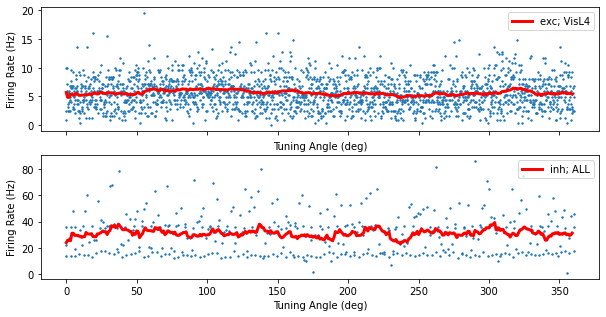

In [12]:
plot_tuning_angle_fr('output/spikes.h5')

.Let us now see what happens if the weight_function takes into account the rules we described above and amplifies signals from similarly tuned neurons. Again, we don’t need to understand all the details of this function, aside from the fact that it favors similarly-tuned neurons to amplify each other’s responses.

In [13]:
from bmtk.simulator import pointnet
from bmtk.simulator.pointnet.pyfunction_cache import synaptic_weight


@synaptic_weight
def DirectionRule_others(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values

    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)
       
    return np.array(syn_weight*w_multiplier_180*nsyn)


@synaptic_weight
def DirectionRule_EE(edge_props, source_nodes, target_nodes):
    src_tuning = source_nodes['tuning_angle'].values
    tar_tuning = target_nodes['tuning_angle'].values
    x_tar = target_nodes['x'].values
    x_src = source_nodes['x'].values
    z_tar = target_nodes['z'].values
    z_src = source_nodes['z'].values
    sigma = edge_props['weight_sigma'].values
    nsyn = edge_props['nsyns'].values
    syn_weight = edge_props['syn_weight'].values
    
    delta_tuning_180 = np.abs(np.abs(np.mod(np.abs(tar_tuning - src_tuning), 360.0) - 180.0) - 180.0)
    w_multiplier_180 = np.exp(-(delta_tuning_180 / sigma) ** 2)

    delta_x = (x_tar - x_src) * 0.07
    delta_z = (z_tar - z_src) * 0.04

    theta_pref = tar_tuning * (np.pi / 180.)
    xz = delta_x * np.cos(theta_pref) + delta_z * np.sin(theta_pref)
    sigma_phase = 1.0
    phase_scale_ratio = np.exp(-(xz**2 / (2*sigma_phase**2)))

    # To account for the 0.07 vs 0.04 dimensions. This ensures the horizontal neurons are scaled by 5.5/4
    # (from the midpoint of 4 & 7). Also, ensures the vertical is scaled by 5.5/7. This was a basic 
    # linear estimate to get the numbers (y = ax + b).
    theta_tar_scale = abs(abs(abs(180.0 - np.mod(np.abs(tar_tuning), 360.0)) - 90.0) - 90.0)
    phase_scale_ratio = phase_scale_ratio * (5.5 / 4.0 - 11.0 / 1680.0 * theta_tar_scale)

    return np.array(syn_weight*w_multiplier_180*phase_scale_ratio*nsyn)


configure = pointnet.Config.from_json('config.simulation_pointnet.recurrent.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

2022-07-14 09:25:12,743 [INFO] Created log file
2022-07-14 09:25:12,768 [INFO] Batch processing nodes for l4/0.
2022-07-14 09:25:12,841 [INFO] Batch processing nodes for lgn/0.
2022-07-14 09:25:12,849 [INFO] Batch processing nodes for bkg/0.
2022-07-14 09:25:12,955 [INFO] Setting up output directory
2022-07-14 09:25:12,957 [INFO] Building cells.
2022-07-14 09:25:12,974 [INFO] Building recurrent connections
2022-07-14 09:25:13,864 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-14 09:25:19,198 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-14 09:25:19,236 [INFO] Network created.
2022-07-14 09:25:19,264 [INFO] Starting Simulation
2022-07-14 09:25:25,917 [INFO] Simulation finished, finalizing results.
2022-07-14 09:25:26,104 [INFO] Done.


Now we can plot the firing rates as a function of the tuning_angle. As we can see on the plots below, the direction selectivity is preserved and even a bit enhanced here.  

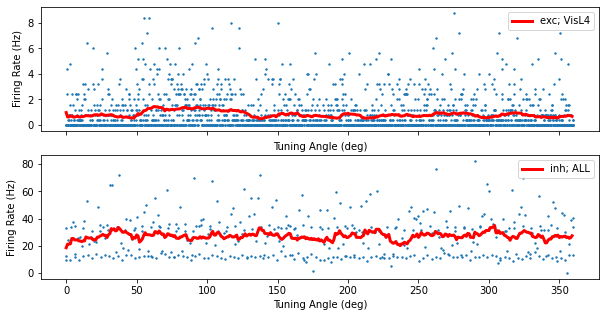

In [14]:
plot_tuning_angle_fr('output/spikes.h5')

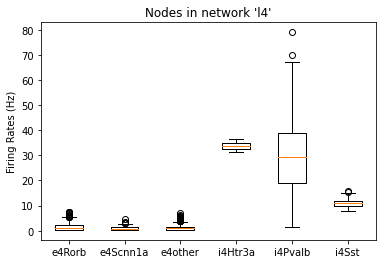

In [15]:
_ = plot_rates_boxplot(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

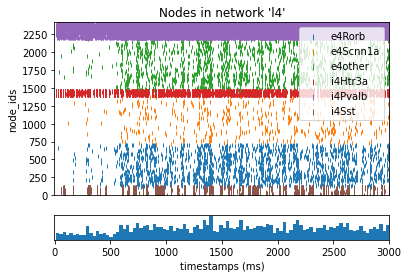

In [16]:
_ = plot_raster(config_file='config.simulation_pointnet.recurrent.json', group_by='cell_line')

The **weight_function** option provides a dynamic way to test and adjust the synaptic weights in ```PointNet``` and ```BioNet``` at simulation time without having to rebuild the network each time - which for large networks can take a significant amount of time. It can also be used to fine tune the synaptic-weight parameters using conjugate-gradient methods or grid searches - examples of which are show in the [this notebook](./6C.%20Parameter%20Tuning.ipynb)

#### Adding Perturbations

A common and useful tool in both in-silico and in-vivo neuroscience is the ability to apply perturbations to the network of interes and its components. BMTK provides a convenient interface for doing that. For example if we want to completely suppress the i4Pvalb cells we can add a strong negative current clamp to the "inputs" section in the json config. Note the parameter "amp" below - this is the amplitude of the applied current in pA. You may need to use different values of "amp" depending on the cell models among the neurons affected by the perturbation and depending on the effect you desire to achieve.

```json
  "inputs": {
    "inh_current_clamp": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {"population": "l4", "cell_line": "i4Pvalb"},
        "amp": -2000.000,
        "delay": 1500.0,
        "duration": 1500.0
      }
```

2022-07-14 09:25:46,076 [INFO] Created log file
2022-07-14 09:25:46,102 [INFO] Batch processing nodes for l4/0.
2022-07-14 09:25:46,173 [INFO] Batch processing nodes for lgn/0.
2022-07-14 09:25:46,181 [INFO] Batch processing nodes for bkg/0.
2022-07-14 09:25:46,285 [INFO] Setting up output directory
2022-07-14 09:25:46,286 [INFO] Building cells.
2022-07-14 09:25:46,308 [INFO] Building recurrent connections
2022-07-14 09:25:47,118 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-14 09:25:52,420 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-14 09:25:52,597 [INFO] Network created.
2022-07-14 09:25:52,624 [INFO] Starting Simulation
2022-07-14 09:26:17,744 [INFO] Simulation finished, finalizing results.
2022-07-14 09:26:17,921 [INFO] Done.


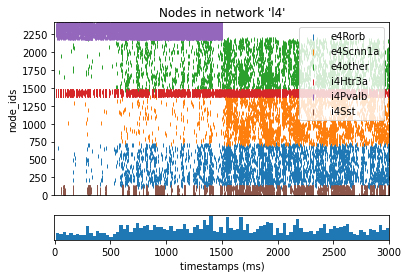

In [17]:
from bmtk.simulator import pointnet

configure = pointnet.Config.from_json('config.simulation_pointnet.pert_pvalb.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_pvalb.json', group_by='cell_line')

Not only are we able to completely knock out the Parvalbumin cells in Layer 4, we can see and compare the effect this has on the rest of the recurrently-connected network. Similarly we can excite the cells with a strong positive current, or even excite/inhibit different cells at different times during the same simulation.

BMTK offers much flexibility in how one defines the population of nodes to which the perturbation is applied. In the example below, we just changed the *node_set* so that it targets only the biophysically detailed "e4Rorb" and "e4Scnn1a" cells, and changed the *amp*litude to a large positive value:

```json
  "inputs": {
    "exc_current_clamp": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
          "population": "l4",
          "model_type": "biophysical",
          "cell_line": ["e4Rorb", "e4Scnn1a"],
        },
        "amp": 2000.000,
        "delay": 1500.0,
        "duration": 1500.0
      }
```

2022-07-14 09:28:45,199 [INFO] Created log file
2022-07-14 09:28:45,228 [INFO] Batch processing nodes for l4/0.
2022-07-14 09:28:45,300 [INFO] Batch processing nodes for lgn/0.
2022-07-14 09:28:45,307 [INFO] Batch processing nodes for bkg/0.
2022-07-14 09:28:45,411 [INFO] Setting up output directory
2022-07-14 09:28:45,412 [INFO] Building cells.
2022-07-14 09:28:45,426 [INFO] Building recurrent connections
2022-07-14 09:28:46,174 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-14 09:28:51,466 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-14 09:28:51,939 [INFO] Network created.
2022-07-14 09:28:51,968 [INFO] Starting Simulation
2022-07-14 09:29:23,917 [INFO] Simulation finished, finalizing results.
2022-07-14 09:29:26,261 [INFO] Done.


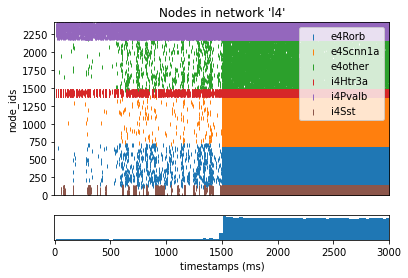

In [18]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_exc.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_exc.json', group_by='cell_line')

We can also run multiple perturbations in the same simulation, in serial or in parallel. We just need to add multiple sections in the "inputs":

```json
  "inputs": {
    "current_clamp_1": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "cell_line": "e4Rorb"
      },
      "amp": -2000.000,
      "delay": 500.0,
      "duration": 500.0
    },
    "current_clamp_2": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "cell_line": "e4Rorb"
      },
      "amp": 2000.000,
      "delay": 1500.0,
      "duration": 500.0
    },
    "current_clamp_3": {
      "input_type": "current_clamp",
      "module": "IClamp",
      "node_set": {
        "population": "l4",
        "ei": "i"
      },
      "amp": -2000.000,
      "delay": 2500.0,
      "duration": 500.0
    }
  },
```

2022-07-14 09:32:09,547 [INFO] Created log file
2022-07-14 09:32:09,578 [INFO] Batch processing nodes for l4/0.
2022-07-14 09:32:09,653 [INFO] Batch processing nodes for lgn/0.
2022-07-14 09:32:09,660 [INFO] Batch processing nodes for bkg/0.
2022-07-14 09:32:09,764 [INFO] Setting up output directory
2022-07-14 09:32:09,765 [INFO] Building cells.
2022-07-14 09:32:09,779 [INFO] Building recurrent connections
2022-07-14 09:32:10,576 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-14 09:32:15,807 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-14 09:32:16,543 [INFO] Network created.
2022-07-14 09:32:16,568 [INFO] Starting Simulation
2022-07-14 09:32:45,359 [INFO] Simulation finished, finalizing results.
2022-07-14 09:32:46,013 [INFO] Done.


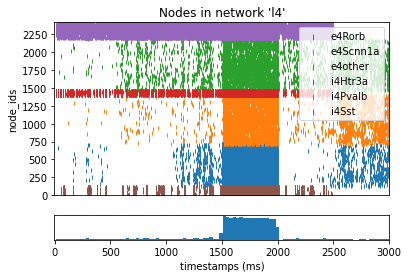

In [19]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_multiple.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_multiple.json', group_by='cell_line')

In the above examples we selected a subset of nodes based on their properties. We also have the option to perterb individual or a more select set of nodes base on their assigned *node_id*s. Here we just have to tell the config the population of nodes to use (since for some models there might be multiple populations in a single simulation) and pass a list of node_ids:

```json
  "inputs": {
    "current_clamp_1": {
        "input_type": "current_clamp",
        "module": "IClamp",
        "node_set": {
          "population": "l4",
          "node_id": [250, 500, 750, 1250, 1500, 1750]
        },
        "amp": 2000.000,
        "delay": 500.0,
        "duration": 2500.0
      }
  },

```

2022-07-14 09:33:10,455 [INFO] Created log file
2022-07-14 09:33:10,482 [INFO] Batch processing nodes for l4/0.
2022-07-14 09:33:10,552 [INFO] Batch processing nodes for lgn/0.
2022-07-14 09:33:10,560 [INFO] Batch processing nodes for bkg/0.
2022-07-14 09:33:10,662 [INFO] Setting up output directory
2022-07-14 09:33:10,663 [INFO] Building cells.
2022-07-14 09:33:10,677 [INFO] Building recurrent connections
2022-07-14 09:33:11,470 [INFO] Build virtual cell stimulations for lgn_spikes
2022-07-14 09:33:16,649 [INFO] Build virtual cell stimulations for bkg_spikes
2022-07-14 09:33:16,798 [INFO] Network created.
2022-07-14 09:33:16,831 [INFO] Starting Simulation
2022-07-14 09:33:45,389 [INFO] Simulation finished, finalizing results.
2022-07-14 09:33:45,592 [INFO] Done.


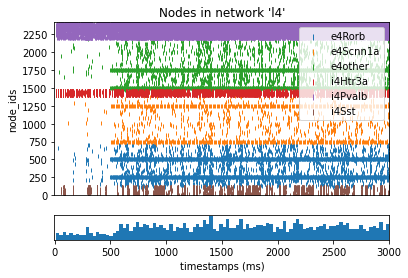

In [20]:
configure = pointnet.Config.from_json('config.simulation_pointnet.pert_individual.json')
configure.build_env()

graph = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, graph)
sim.run()

_ = plot_raster(config_file='config.simulation_pointnet.pert_individual.json', group_by='cell_line')